#Imports

1.   Needed packages
2.   Google Drive connection
3.   Definition of the model and Grid Search hyperparams



In [ ]:
!pip install -U kaleido # instalations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd # librarys
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from collections import Counter

In [ ]:
from google.colab import drive # # drive connection

drive.mount('/content/gdrive', force_remount=True)
path = 'PATH_TO_DATASET_IN_DRIVE'

Mounted at /content/gdrive


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model_used_name = 'gbm'

param_grid = [ # MUDAR AQUI <-----------------------------------------------
    {
        'learning_rate': [0.001, 0.01, 0.1],
        'min_samples_split': range(200, 1001, 200),
        'min_samples_leaf': [1, 25, 50, 100, 250, 500],
        'max_depth': [1, 5, 9, 13, 17, None],
        'max_features': ['sqrt', 'log2', None],
        'subsample': [0.8],
        'n_estimators': [20, 50, 100, 500, 1000],
        'random_state': [42]
    }
]

#Functions definition

In [ ]:
def read_base(name_path, folder_name, name_name): # read the folder
  base = pd.read_csv(name_path+folder_name+name_name+'.csv', sep=',')
  return base

In [ ]:
def define_metrics(true_n, false_p, false_n, true_p, y_test, y_prediction):
  acc = (true_p+true_n)/(true_p+true_n+false_p+false_n)
  prec = (true_p)/(true_p+false_p)
  rec = (true_p)/(true_p+false_n)
  spec = (true_n)/(true_n+false_p)
  f1 = ((2*(prec*rec))/(prec+rec))
  auc_roc = metrics.roc_auc_score(y_test, y_prediction)

  return acc, prec, rec, spec, f1, auc_roc

In [ ]:
def apply_grid_model(pre_processed_base, ml_model, params_grid):
  X = pre_processed_base.drop(labels=['mc_cri_vdrl'], axis=1, inplace=False) # selecting x
  y = pre_processed_base['mc_cri_vdrl']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # train and test division
  print('Training class:', Counter(y_train))
  print('Test class:', Counter(y_test))

  #ml_model = ml_model()
  model_grid = GridSearchCV(estimator=ml_model(), param_grid=params_grid, cv=5, scoring='roc_auc', n_jobs=-1)
  model_grid.fit(X_train, y_train)

  print(f'Best score: {model_grid.best_score_}')
  print(f'Best params: {model_grid.best_params_}')

  modelo = model_grid.best_estimator_
  y_pred = modelo.predict(X_test)

  met_hip = metrics.confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = met_hip.ravel()
  acc, prec, rec, spec, f1, auc_roc = define_metrics(tn, fp, fn, tp, y_test, y_pred)
  print(f'\nAcuraccy: {acc} | Precision: {prec} | Sensitivity: {rec}')
  print(f'Specificity: {spec} | F1-score: {f1} | AUC ROC: {auc_roc}\n')

  print(classification_report(y_test, y_pred))

  cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
  disp.plot(cmap='Blues')
  plt.show()

  hiperparams_best_model = pd.DataFrame(model_grid.best_params_, index=[0])
  hiperparams_best_model.to_csv(path+pasta_1+pasta_2+modelo_pasta+'best_grid/'+nome_modelo+nome+'_MODELO.csv')
  print(hiperparams_best_model)

  evaluation_metrics = pd.DataFrame(dict({
      'accuracy': [acc], 'Precision': [prec], 'Sensitivity': [rec], 'Specificity': [spec], 'f1-score': [f1], 'AUC ROC': [auc_roc]
  }))
  evaluation_metrics.to_csv(path+pasta_1+pasta_2+modelo_pasta+nome_modelo+nome+tipo_teste+'.csv')

  print(evaluation_metrics.head())

  metrics_graph = pd.DataFrame(dict(
      r=[acc, prec, rec, spec, f1, auc_roc],
      theta=['Acuraccy', 'Precision', 'Sensitivity', 'Specificity',
          'F1-score', 'AUC ROC']
  ))

  fig_graphic_metrics = px.line_polar(metrics_graph, r='r', theta='theta', line_close=True, range_r=[0.0, 1.0])
  fig_graphic_metrics.show()

  fig_graphic_metrics.write_image(file=path+pasta_1+pasta_2+modelo_pasta+nome_modelo+nome+tipo_teste+'.png')

#Loading

1.   Folders
2.   Database



In [ ]:
pasta = 'bases-pre-proc/'
tec_imp = 'moda_'

#tec_bal = 'random_under' # Balancing tecnique
#tec_bal = 'near_miss_1_k'
#tec_bal = 'near_miss_2_k'
#tec_bal = 'near_miss_3_k'
tec_bal = 'sbc'

#valor_k = '9' # NEARMISS HYPERPARAMS
#valor_k2 = '11'

#nome = 'base_'+tec_imp+tec_bal # NOME DA BASE TOTAL
#nome = 'base_'+tec_imp+tec_bal+'_NORMALIZADO'
#nome = 'base_'+tec_imp+tec_bal+valor_k+'_NORMALIZADO'
#nome = 'base_'+tec_imp+tec_bal+valor_k+valor_k2+'_NORMALIZADO' # NEARMISS3
#pasta_2 = 'base_total/' # <-----------------------------------------------

nome = 'base_'+tec_imp+tec_bal+'_RECORTE_FEITO_NORMALIZADO' # NOME DA BASE REDUZIDA
#nome = 'base_'+tec_imp+tec_bal+valor_k+'_RECORTE_FEITO_NORMALIZADO'
#nome = 'base_'+tec_imp+tec_bal+valor_k+valor_k2+'_RECORTE_FEITO_NORMALIZADO' # NEARMISS3
pasta_2 = 'base_reduzida/' # <-----------------------------------------------

#nome = 'base_pre_proc_desb_imp_moda_NORMALIZADO' # para a base desbalanceada
#nome = 'base_pre_proc_desb_imp_moda_RECORTE_FEITO_NORMALIZADO'

modelo_pasta = model_used_name+'/' # <-----------------------------------------------
nome_modelo = model_used_name+'_' # <-----------------------------------------------

pasta_1 = 'resultados/'

#tipo_teste = '_random_under_NORMALIZADO'
tipo_teste = '_sbc_NORMALIZADO'
#tipo_teste = '_near_miss_NORMALIZADO'
#tipo_teste = '_desb_NORMALIZADO'

In [ ]:
base = read_base(path, pasta, nome) # loading dataset
print(base['mc_cri_vdrl'].value_counts())
base.head()

0.0    863
1.0    862
Name: mc_cri_vdrl, dtype: int64


,mc_cri_vdrl,mc_get_risco_gestacional,mc_mul_est_civil,mc_mul_nivel_inseguranca,mc_mul_qtd_aborto,mc_mul_qtd_filhos_vivos,mc_mul_qtd_gest,mc_mul_rec_inf_plan_fam,mc_mul_tipo_const_casa,mc_dae_escolaridade,mc_dae_rfa,idade
0,1.0,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.8,0.500,0.25,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8,0.250,1.00,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.625,0.50,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.8,0.500,0.50,1.0
4,1.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.8,0.500,0.50,1.0


#Model application

Classes no treino: Counter({0.0: 604, 1.0: 603})
Classes no teste: Counter({0.0: 259, 1.0: 259})
Best score: 0.6117052000091069
Best params: {'learning_rate': 0.1, 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 400, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.8}

Acurácia: 0.583011583011583 | Precisão: 0.5843137254901961 | Sensibilidade: 0.5752895752895753
Especificidade: 0.5907335907335908 | F1-score: 0.5797665369649805 | AUC ROC: 0.583011583011583

              precision    recall  f1-score   support

         0.0       0.58      0.59      0.59       259
         1.0       0.58      0.58      0.58       259

    accuracy                           0.58       518
   macro avg       0.58      0.58      0.58       518
weighted avg       0.58      0.58      0.58       518



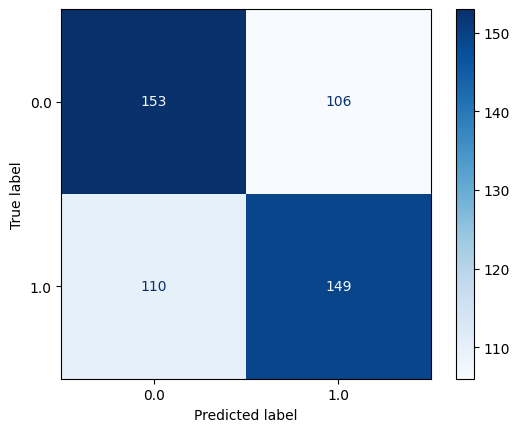

   learning_rate  max_depth max_features  min_samples_leaf  min_samples_split  \
0            0.1         13         None                 1                400   

   n_estimators  random_state  subsample  
0           100            42        0.8  
   acuracia  precisao  sensibilidade  especificidade  f1-score   AUC ROC
0  0.583012  0.584314        0.57529        0.590734  0.579767  0.583012


/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])


In [ ]:
apply_grid_model(base, GradientBoostingClassifier, param_grid)